In [110]:
import jax.numpy as jnp
import functools
import jax
from jax.scipy.signal import convolve2d
from jax.scipy import signal
import matplotlib.pyplot as plt
import cv2
import numpy as np

(775, 1024)

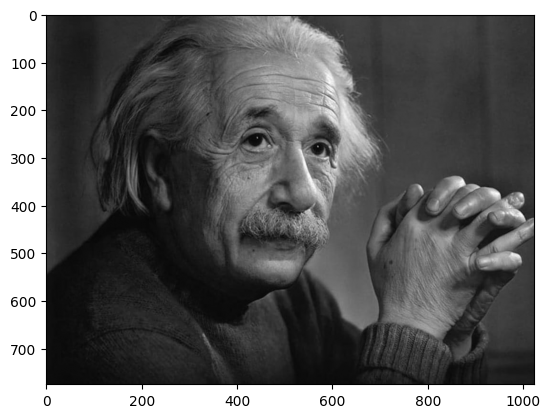

In [2]:
image = cv2.imread('data/einstein.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.mean(axis=2)
plt.imshow(image, cmap='gray')
image.shape

# Image filtering: convolution: convolution, 2-D 

This is taken from the website: https://www.youtube.com/watch?v=4Y_iestloSk&list=PLhwIOYE-ldwL6h-peJADfNm8bbO3GlKEy&index=21

In [3]:
blur_kernel = jnp.array([
    [1/16, 1/8, 1/16],
    [1/8 , 1/4, 1/8 ],
    [1/16, 1/8, 1/16],
])

sharpen_kernel = jnp.array([
    [0.0091, -0.1134, 0.0091],
    [-0.1134, 1.4172, -0.1134],
    [0.0091, -0.1134, 0.0091],
])

# blur_kernel, sharpen_kernel

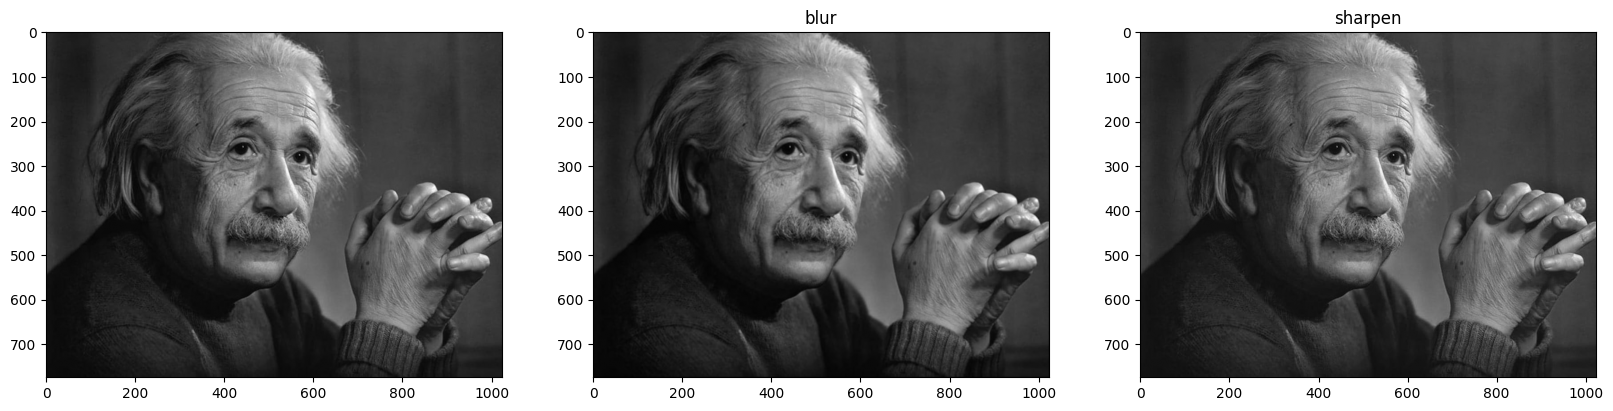

In [4]:
plt.figure(figsize=(20, 6))
plt.subplot(1,3,1)
plt.imshow(
    image,
    cmap = plt.cm.gray,
)
plt.subplot(1,3,2)
plt.imshow(
    convolve2d( image, blur_kernel, mode='same' ),
    cmap = plt.cm.gray,
)
plt.title('blur')
plt.subplot(1,3,3)
plt.imshow(
    convolve2d( image, sharpen_kernel, mode='same' ),
    cmap = plt.cm.gray,
)
plt.title('sharpen')
plt.savefig('results/image_filters.png', dpi=300)

In [63]:
vertical_df_kernel = jnp.array([
    [-1/8, -1/4, -1/8],
    [0, 0, 0],
    [1/8, 1/4, 1/8],
])


horizontal_df_kernel = vertical_df_kernel.T


In [64]:
vertical_df_kernel

Array([[-0.125, -0.25 , -0.125],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.125,  0.25 ,  0.125]], dtype=float32)

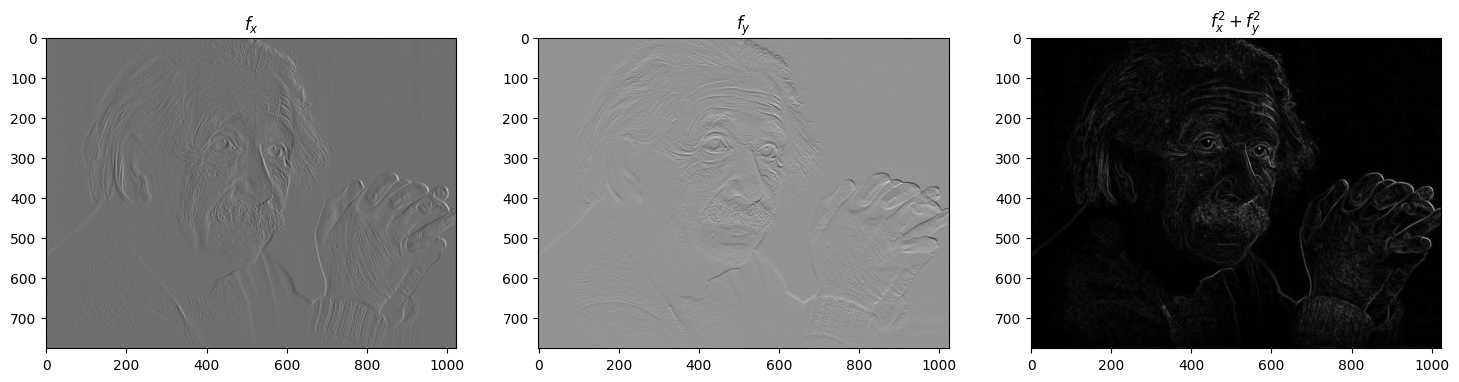

In [65]:
plt.figure(figsize=(18, 6))

plt.subplot(1,3,1)
fx = convolve2d( image, horizontal_df_kernel, mode='same' )
plt.imshow(
    fx, cmap = plt.cm.gray,
)
plt.title('$f_x$')

plt.subplot(1,3,2)
fy = convolve2d( image, vertical_df_kernel, mode='same' )
plt.imshow(
    fy, cmap = plt.cm.gray,
)
plt.title('$f_y$')

plt.subplot(1,3,3)
plt.imshow(
    jnp.sqrt(fx**2+fy**2), cmap = plt.cm.gray,
)
plt.title('$f_x^2 + f_y^2$')

plt.savefig('results/image_diff_filter.png', dpi=300)


In [81]:
u, s, vT = jnp.linalg.svd( vertical_df_kernel, full_matrices=False )
print(u.shape, s.shape, vT.shape)
u @ np.diag(s) @ vT

(3, 3) (3,) (3, 3)


Array([[-0.12500003, -0.25000006, -0.12500004],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.12500003,  0.25000006,  0.12500003]], dtype=float32)

In [79]:
f1 = u[:, 0]
f2 = vT[:, 1]
f1, f2


(Array([-0.7071069,  0.       ,  0.7071068], dtype=float32),
 Array([ 0.81649655, -0.3651484 , -0.4472136 ], dtype=float32))

Array([[-0.12500003, -0.25000006, -0.12500004],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.12500003,  0.25000006,  0.12500003]], dtype=float32)

In [ ]:
signal.convolve( image[0, :], jnp.array([-1/8, 0, 1/8]) )

Array([-6.2083335, -6.2083335,  0.125    , ...,  0.25     ,  6.625    ,
        6.5      ], dtype=float32)

In [104]:
convolve1d_x = jax.vmap( signal.convolve, in_axes=(0, None) )
convolve1d_y = jax.vmap( signal.convolve, in_axes=(1, None) )

(775, 1026) (777, 1024)


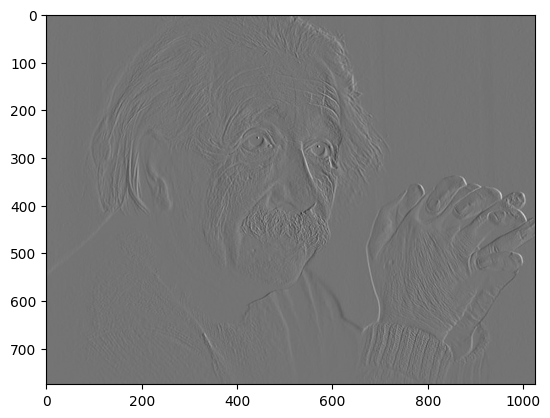

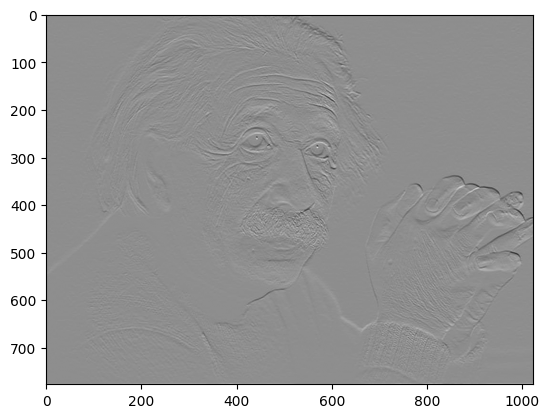

In [107]:
fx = convolve1d_x(image, jnp.array([-1/8, 0, 1/8]))
fy = convolve1d_y(image, jnp.array([-1/8, 0, 1/8])).T
plt.figure()
plt.imshow(fx, cmap=plt.cm.gray)
plt.figure()
plt.imshow(fy, cmap = plt.cm.gray)

print(fx.shape, fy.shape)

In [117]:
def sepfir2(image, hx, hy):

    c1d = functools.partial( signal.convolve, mode='same' )

    convolve1d_x = jax.vmap( c1d, in_axes=(0, None) )
    convolve1d_y = jax.vmap( c1d, in_axes=(1, None) )

    temp1 = convolve1d_x(image, hx)
    temp2 = convolve1d_y(temp1, hy).T

    return temp2

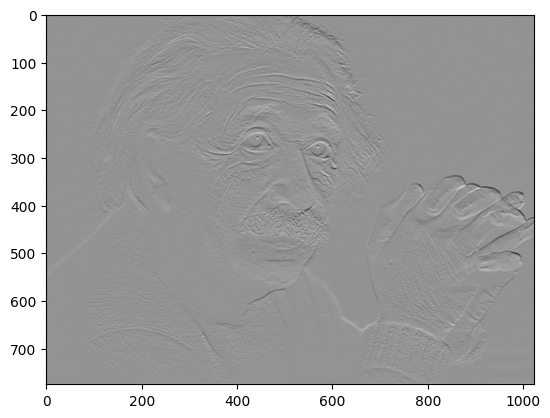

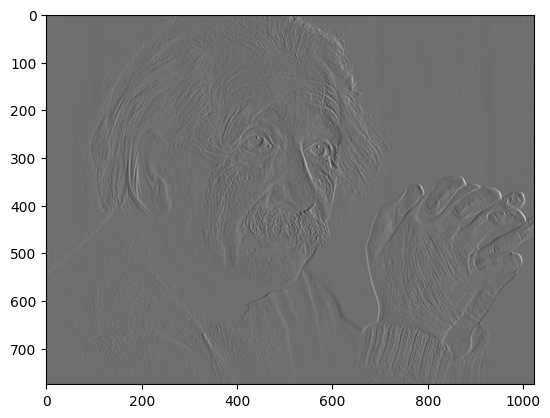

In [122]:
f1 = jnp.array([0.4082482, 0.81649658, 0.4082482])
f2 = jnp.array([-0.70710678, 0, 0.70710678])
# f1 = u[:, 0] # I dont know how to get these values
# f2 = vT[:, 1]
img_y = sepfir2(image, f1, f2)
img_x = sepfir2(image, f2, f1)
plt.figure()
plt.imshow(img_y, cmap = plt.cm.gray)
plt.figure()
plt.imshow(img_x, cmap = plt.cm.gray)

# Appendix

Creating a convolution kernel

In [7]:
x, y = jnp.meshgrid(jnp.linspace(-5, 5, 11), jnp.linspace(-5, 5, 11))
r = jnp.sqrt(x**2 + y**2)
sigma = 3
gaus  = ( 1 / (sigma * jnp.sqrt(2*jnp.pi))  )*jnp.exp( -r**2/sigma**2 )
gaus /= gaus.sum()

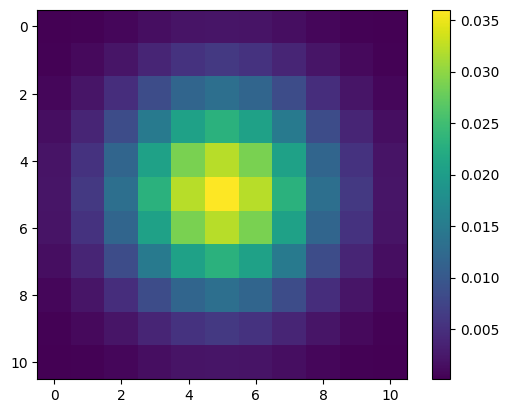

In [8]:
plt.imshow(gaus)
plt.colorbar()

In [9]:
plt.imshow(image.mean(axis=2), cmap=plt.cm.gray)

AxisError: axis 2 is out of bounds for array of dimension 2

In [ ]:
image1 = convolve2d( image.mean(axis=2), gaus, mode='same' )

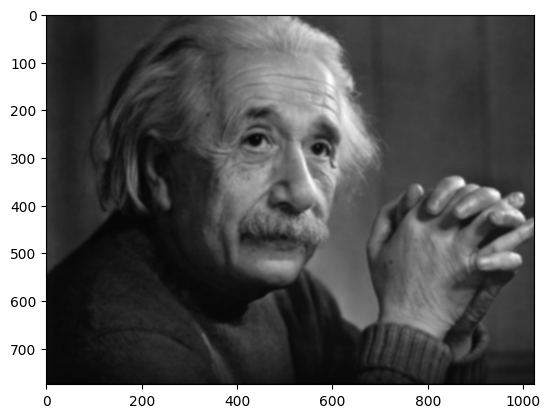

In [ ]:
plt.imshow(image1, cmap=plt.cm.gray)